In [1]:
import meep as mp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

n = 3.4
w = 1
r = 1
pad = 4
dpml = 2

sxy = 2*(r+w+pad+dpml)
vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sxy-2*dpml,sxy-2*dpml))

c1 = mp.Cylinder(radius=r+w, material=mp.Medium(index=n))
c2 = mp.Cylinder(radius=r)

fcen = 0.118
df = 0.08
src = [mp.Source(mp.ContinuousSource(fcen,fwidth=df),
                 component=mp.Ez,
                 center=mp.Vector3(r+0.1))]

sim = mp.Simulation(cell_size=mp.Vector3(sxy,sxy),
                    geometry=[c1,c2],
                    sources=src,
                    resolution=10,
                    force_complex_fields=True,
                    symmetries=[mp.Mirror(mp.Y)],
                    boundary_layers=[mp.PML(dpml)])

num_tols = 5
tols = np.power(10, np.arange(-8.0,-8.0-num_tols,-1.0))
ez_dat = np.zeros((122,122,num_tols), dtype=np.complex_)

for i in range(num_tols):
    sim.init_sim()
    sim.solve_cw(tols[i], 10000, 10)
    ez_dat[:,:,i] = sim.get_array(vol=vol, component=mp.Ez)

-----------
Initializing structure...
Meep: using complex fields.


Text(0, 0.5, 'L2 norm of error in fields')

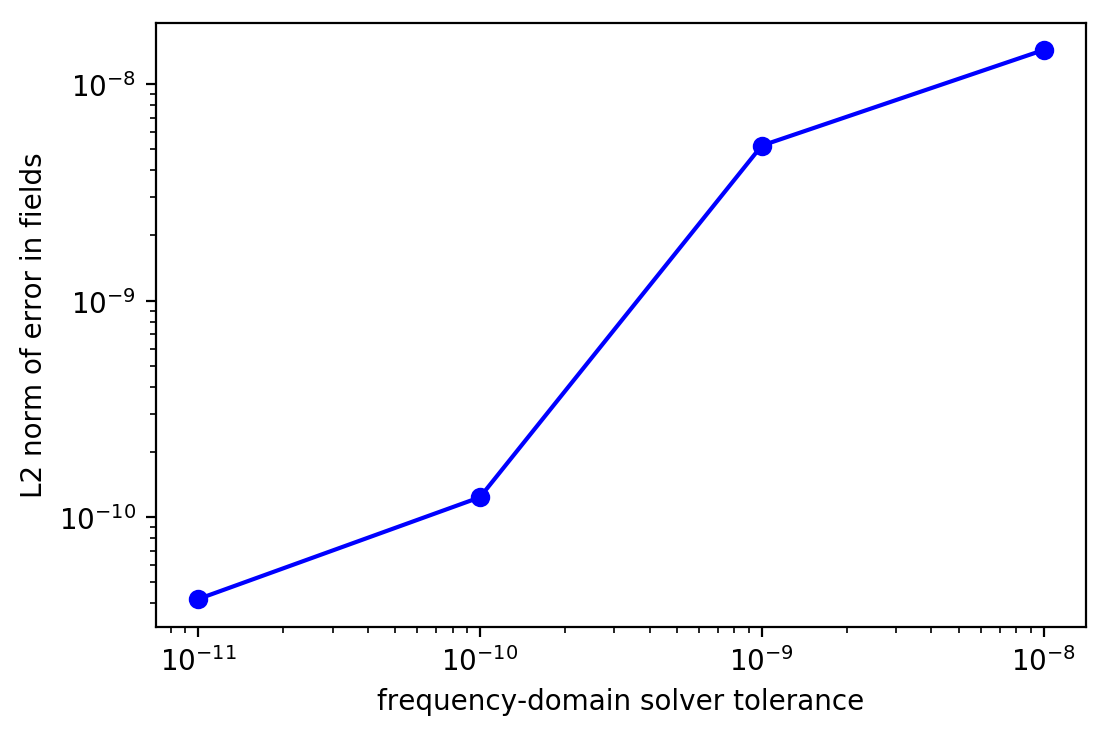

In [2]:
err_dat = np.zeros(num_tols-1)
for i in range(num_tols-1):
    err_dat[i] = LA.norm(ez_dat[:,:,i]-ez_dat[:,:,num_tols-1])

plt.figure(dpi=200)
plt.loglog(tols[:num_tols-1], err_dat, 'bo-')
plt.xlabel("frequency-domain solver tolerance")
plt.ylabel("L2 norm of error in fields")

PASSED solve_cw test: error in the fields is decreasing with increasing resolution


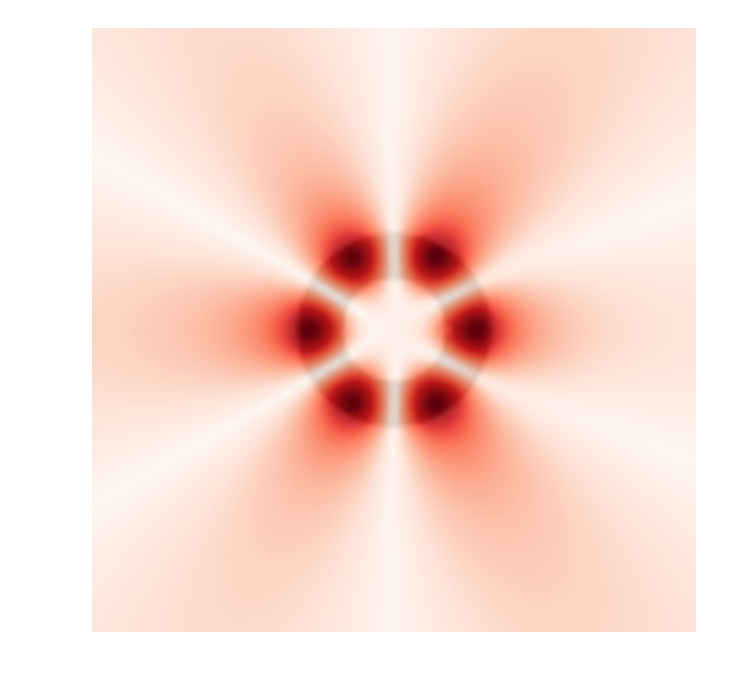

In [3]:
eps_data = sim.get_array(vol=vol, component=mp.Dielectric)
ez_data = np.absolute(ez_dat[:,:,num_tols-1])

plt.figure(dpi=200)
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='Reds', alpha=0.9)
plt.axis('off')

if np.all(np.diff(err_dat) < 0):
    print("PASSED solve_cw test: error in the fields is decreasing with increasing resolution")
else:
    print("FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution")

In [4]:
sim.reset_meep()

src = mp.Source(mp.GaussianSource(fcen,fwidth=df),
                component=mp.Ez,
                center=mp.Vector3(r+0.1))

sim = mp.Simulation(cell_size=mp.Vector3(sxy,sxy),
                    geometry=[c1,c2],
                    sources=[src],
                    resolution=10,
                    symmetries=[mp.Mirror(mp.Y)],
                    boundary_layers=[mp.PML(dpml)])

dfts = sim.add_dft_fields([mp.Ez], fcen, fcen, 1, where=vol)

sim.run(until_after_sources=100)

-----------
Initializing structure...
run 0 finished at t = 225.0 (4500 timesteps)


(-0.5, 121.5, 121.5, -0.5)

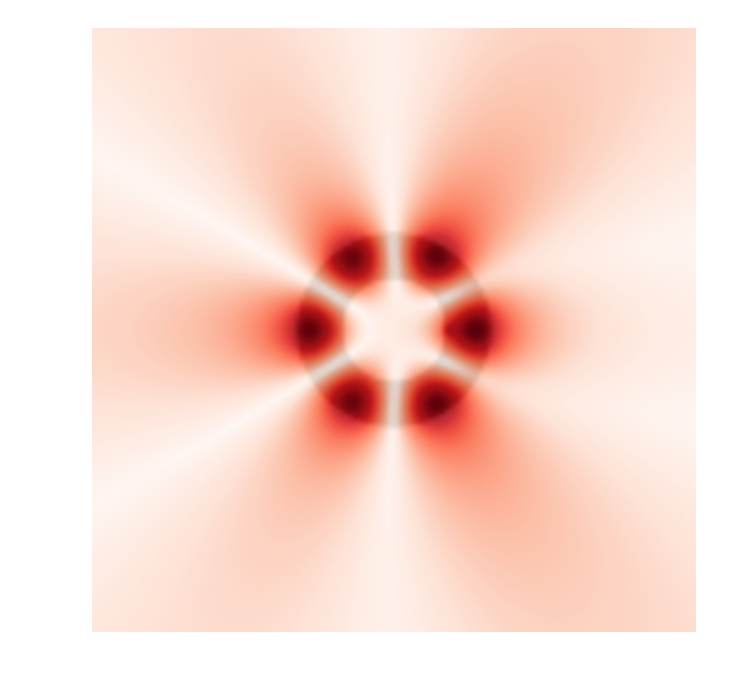

In [5]:
eps_data = sim.get_array(vol=vol, component=mp.Dielectric)
ez_data = np.absolute(sim.get_dft_array(dfts, mp.Ez, 0))

plt.figure(dpi=200)
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='Reds', alpha=0.9)
plt.axis('off')